# 神经网络预测流量数据

In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)

## 1. 载入数据

In [12]:
path = 'data/project1_data.csv'
pd_data = pd.read_csv(path,nrows=100000)
pd_data.head()

,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,26/04/201711:11:17,45523,22,55,...,0.0,0,0,0.0,0.0,0,0,BENIGN,131,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,26/04/201711:11:17,1,2,0,...,0.0,0,0,0.0,0.0,0,0,BENIGN,131,HTTP_PROXY
2,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,1,3,0,...,0.0,0,0,0.0,0.0,0,0,BENIGN,7,HTTP
3,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,217,1,3,...,0.0,0,0,0.0,0.0,0,0,BENIGN,7,HTTP
4,192.168.72.43-10.200.7.7-55961-3128-6,192.168.72.43,55961,10.200.7.7,3128,6,26/04/201711:11:17,78068,5,0,...,0.0,0,0,0.0,0.0,0,0,BENIGN,131,HTTP_PROXY


In [13]:
pd_data.keys()

Index(['Flow.ID', 'Source.IP', 'Source.Port', 'Destination.IP',
       'Destination.Port', 'Protocol', 'Timestamp', 'Flow.Duration',
       'Total.Fwd.Packets', 'Total.Backward.Packets',
       'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets',
       'Fwd.Packet.Length.Max', 'Fwd.Packet.Length.Min',
       'Fwd.Packet.Length.Mean', 'Fwd.Packet.Length.Std',
       'Bwd.Packet.Length.Max', 'Bwd.Packet.Length.Min',
       'Bwd.Packet.Length.Mean', 'Bwd.Packet.Length.Std', 'Flow.Bytes.s',
       'Flow.Packets.s', 'Flow.IAT.Mean', 'Flow.IAT.Std', 'Flow.IAT.Max',
       'Flow.IAT.Min', 'Fwd.IAT.Total', 'Fwd.IAT.Mean', 'Fwd.IAT.Std',
       'Fwd.IAT.Max', 'Fwd.IAT.Min', 'Bwd.IAT.Total', 'Bwd.IAT.Mean',
       'Bwd.IAT.Std', 'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.PSH.Flags',
       'Bwd.PSH.Flags', 'Fwd.URG.Flags', 'Bwd.URG.Flags', 'Fwd.Header.Length',
       'Bwd.Header.Length', 'Fwd.Packets.s', 'Bwd.Packets.s',
       'Min.Packet.Length', 'Max.Packet.Length', 'Packet.Length.Mean',
  

## 2 数据处理

In [14]:
drop_ids = ['Flow.Packets.s','Flow.Bytes.s','Flow.ID','Source.IP', 'Source.Port','Destination.IP','Destination.Port','Timestamp','Label','L7Protocol','ProtocolName']
target_fields = 'Flow.Packets.s'

In [15]:
Datas = pd_data.drop(drop_ids, axis=1)
D_mean = Datas.mean(axis=0)
D_std = Datas.std(axis=0)
Datas = (Datas - D_mean) / D_std
Datas = Datas.fillna(0)
Labels = pd_data.loc[:,target_fields]
result_mean = Labels.mean()
result_std = Labels.std()
Labels = (Labels - result_mean) / result_std
train_features, train_targets = Datas.iloc[:-2000], Labels.iloc[:-2000]
val_features, val_targets = Datas.iloc[-2000:-1000], Labels.iloc[-2000:-1000]
test_features, test_targets = Datas.iloc[-1000:], Labels.iloc[-1000:]
print(train_features.shape, train_targets.shape)
print(val_features.shape, val_targets.shape)
print(test_features.shape, test_targets.shape)

(98000, 76) (98000,)
(1000, 76) (1000,)
(1000, 76) (1000,)


## 3 编写神经网络

In [16]:
def create_model():
    INPUT = tf.keras.Input((76,))
    X = tf.keras.layers.Dense(8, activation='sigmoid')(INPUT)
    X = tf.keras.layers.Dense(8, activation='sigmoid')(X)
    Y = tf.keras.layers.Dense(1, activation=None)(X)
    model = tf.keras.Model(inputs=INPUT, outputs=Y)
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.07),
                  loss=tf.keras.losses.MeanAbsoluteError())
    
    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 616       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 697
Trainable params: 697
Non-trainable params: 0
_________________________________________________________________


## 4. 开始训练

In [17]:
batch_size = 256
epochs = 100

log = model.fit(train_features,
                train_targets,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=[val_features, val_targets])

W0529 10:59:50.866728 11084 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 98000 samples, validate on 1000 samples
Epoch 1/100
98000/98000 [==============================] - 2s 17us/sample - loss: 0.3409 - val_loss: 0.1199
Epoch 2/100
98000/98000 [==============================] - 1s 15us/sample - loss: 0.3265 - val_loss: 0.1958
Epoch 3/100
98000/98000 [==============================] - 2s 16us/sample - loss: 0.3145 - val_loss: 0.1201
Epoch 4/100
98000/98000 [==============================] - 2s 16us/sample - loss: 0.3040 - val_loss: 0.1124
Epoch 5/100
98000/98000 [==============================] - 1s 15us/sample - loss: 0.2906 - val_loss: 0.1893
Epoch 6/100
98000/98000 [==============================] - 1s 13us/sample - loss: 0.2680 - val_loss: 0.1056
Epoch 7/100
98000/98000 [==============================] - 1s 12us/sample - loss: 0.2264 - val_loss: 0.1927
Epoch 8/100
98000/98000 [==============================] - 1s 15us/sample - loss: 0.1638 - val_loss: 0.1149
Epoch 9/100
98000/98000 [==============================] - 2s 17us/sample - loss: 0.111

Epoch 76/100
98000/98000 [==============================] - 1s 14us/sample - loss: 0.0416 - val_loss: 0.0220
Epoch 77/100
98000/98000 [==============================] - 1s 14us/sample - loss: 0.0412 - val_loss: 0.0552
Epoch 78/100
98000/98000 [==============================] - 1s 13us/sample - loss: 0.0417 - val_loss: 0.0281
Epoch 79/100
98000/98000 [==============================] - 1s 15us/sample - loss: 0.0413 - val_loss: 0.0525
Epoch 80/100
98000/98000 [==============================] - 1s 14us/sample - loss: 0.0414 - val_loss: 0.0291
Epoch 81/100
98000/98000 [==============================] - 1s 13us/sample - loss: 0.0408 - val_loss: 0.0539
Epoch 82/100
98000/98000 [==============================] - 1s 15us/sample - loss: 0.0415 - val_loss: 0.0282
Epoch 83/100
98000/98000 [==============================] - 1s 15us/sample - loss: 0.0412 - val_loss: 0.0536
Epoch 84/100
98000/98000 [==============================] - 1s 13us/sample - loss: 0.0413 - val_loss: 0.0258
Epoch 85/100
98000/

## 5. 可视化训练过程与结果

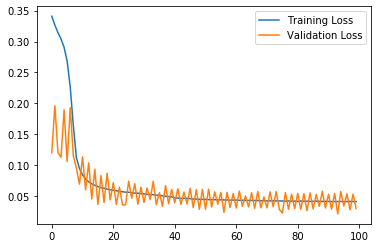

In [18]:
plt.plot(log.history['loss'],label='Training Loss')
plt.plot(log.history['val_loss'], label='Validation Loss')
plt.legend()

W0529 11:10:52.579810 11084 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


90


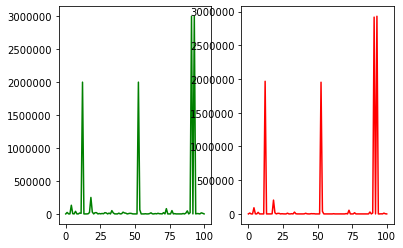

In [19]:
rand_num = np.random.choice(900)
#rand_num=765
print(rand_num)
results = model.predict(test_features[rand_num:rand_num+100]).squeeze()
results = results * result_std + result_mean
results = np.where(results<0, 0, results)
labels = test_targets[rand_num:rand_num+100].to_numpy() * result_std + result_mean

plt_x = np.linspace(0,100,100)
plt.subplot(121)
plt.plot(plt_x, labels, 'g')
plt.subplot(122)
plt.plot(plt_x, results, 'r')
plt.show()

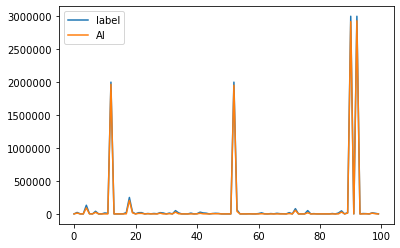

In [20]:
plt.plot(labels,label='label')
plt.plot(results, label='AI')
plt.legend()